In [25]:
import random
import math
import copy
from time import time


def read_bpp_file(file_path):
    with open(file_path, 'r') as f:
        n = int(f.readline().strip())
        capacity = int(f.readline().strip())
        objects = [int(line.strip()) for line in f]
    return (n, capacity, objects)


(n , bin_capacity , items ) = read_bpp_file('benchmark180.txt')
#random.shuffle(items)

In [26]:
n

180

# New Section
RECUIT SIMULE

In [27]:
 # Define the simulated annealing function
def simulated_annealing(items, bin_capacity, initial_temperature, cooling_rate, nb_iter):
    # Define the initial states
    current_state = initial_state(items, bin_capacity)
    current_energy = best_score = energy(current_state)
    best_state = current_state
    print("Start state", best_score)

    # Define the initial temperature
    current_temperature = initial_temperature
    start_time = time()

    # Loop until the temperature is too low
    while current_temperature > 1:
        # loop for nb_iter with same temperature
        for _ in range(nb_iter):
            # Pick a random neighbor state
            neighbor_state, diff = neighbor(current_state, bin_capacity)

            # Calculate the energy of the neighbor states
            neighbor_energy = energy(neighbor_state)

            # Calculate the energy difference
            energy_difference = (neighbor_energy - current_energy) * bin_capacity + diff

            # If the neighbor state has a lower energy, move to that state or with a certain probability
            if energy_difference < 0 or energy_difference > 0 and math.exp(-energy_difference / current_temperature) > random.random():
                current_state = neighbor_state
                current_energy = neighbor_energy

            # If current state better than the best one, update it
            if current_energy < best_score:
                best_state = current_state
                best_score = current_energy
        # Decrease the temperature
        current_temperature *= cooling_rate

    print('exe time', time() - start_time)
    # Return the best state found
    return best_state

# Define the initial state function
def initial_state(items, bin_capacity):
    # next fit wa9ila
    state = []
    bin = []
    for item in items:
        if sum(bin) + item <= bin_capacity:
            bin.append(item)
        else:
            state.append(bin)
            bin = [item]
    state.append(bin)
    return state
    # first fit
    """bins = []
    for item in items:
        # on vérifie s'il y a un bin disponible pour accueillir l'objet
        sol_found = False
        for bin in bins:
            if sum(bin) + item <= bin_capacity:
                bin.append(item)
                sol_found = True
                break
        # Si aucun bin n'est disponible on crée un nouveau bin pour l'objet
        if not sol_found:
            new_bin = [item]
            bins.append(new_bin)
    return bins"""

# Define the neighbor function
def neighbor(state, bin_capacity):
    i = random.randint(0, len(state)-1)  # random bin 1
    j = random.randint(0, len(state[i])-1)  # random object from bin 1
    k = random.randint(0, len(state)-1)  # random bin 2

    # if different bins and object from bin 1 can be added to bin 2, else do nothing
    if i != k and sum(state[k]) + state[i][j] <= bin_capacity:
        neighbor_state = copy.deepcopy(state)
        neighbor_state[k].append(neighbor_state[i].pop(j))
        if not neighbor_state[i]:  # remove bin 1 if it becomes empty
            neighbor_state.pop(i)
            return neighbor_state, 0
        return neighbor_state, sum(neighbor_state[i]) - sum(neighbor_state[k])
        # if nb of bins didn't change then we estimate the change by (i + object)² + k² - (i² + (k + object)²) = 2*object*(i - k) ~ i - k
        # the idea is to try to remplir un bin au maximum (min leftover space in a bin)
    return state, 0

# Define the energy function
def energy(state):
    return len(state)

# Test the algorithm
initial_temperature = n ** 3
cooling_rate = 0.9999

best_state = simulated_annealing(items, bin_capacity, initial_temperature, cooling_rate, 5)
print(best_state)
print(len(best_state))


Start state 96
exe time 10.259770393371582
[[566, 270], [432, 137, 76, 211, 113], [682, 226], [680, 106, 77, 88], [677, 275], [676, 310], [671, 145], [664, 189], [661, 153, 135, 44], [650, 67, 270], [636, 357], [630, 288], [626, 308], [585, 328, 27, 46], [616, 339], [543, 407], [688, 288], [607, 183, 168], [491, 228, 198, 50], [516, 474], [599, 118, 202], [555, 379, 45], [528, 454, 9], [573, 361], [578, 304], [572, 390], [566, 172, 202], [439, 514], [565, 428], [509, 343, 139], [552, 420], [532, 267, 177], [470, 264, 253], [535, 425], [423, 540], [663, 310], [606, 323], [444, 155, 334], [624, 292], [481, 443, 76], [420, 498, 60], [570, 410], [405, 400, 189], [579, 421], [465, 326, 203], [508, 364], [593, 105], [517, 439], [356, 341, 301], [543, 398], [697, 274], [584, 372], [489, 455], [532, 464], [506, 453], [608, 368], [321, 170, 393], [608, 306, 38], [646, 222, 105], [578, 414], [512, 346, 116], [511, 475], [400, 281, 272, 46], [525, 395], [499, 409, 63], [644, 76, 16], [601, 222], 



# New Section FOR AG

In [21]:
import numpy as np
import copy
from multiprocessing import cpu_count, Pool
from time import time

np.random.seed(0)
B = 0
C = 0
class Item:
    def __init__(self, label: int = None, size: int = None):
        self._label = label
        self._size = size


class Bin:
    def __init__(self, items: list = None, capacity: int = 0):
        if items is None:
            items = []
        self._items = items
        self._capacity = capacity

    def add_item(self, item: Item):
        self._items.append(item)
        self._capacity += item._size

    def get_labels(self):
        return [item._label for item in self._items]


class Chromosome:
    def __init__(self, bins: list = None, max_capacity: int = 0):
        if bins is None:
            bins = []
        self._bins = bins
        self._max_capacity = max_capacity
        self._fitness = None

    def calculate_fitness(self):
        """somme(taille bin / max)² for each bin / nb bins"""
        num_bins = len(self._bins)
        bins_capacity = np.asarray([_bin._capacity for _bin in self._bins], dtype=int)
        self._fitness = np.sum(np.power(bins_capacity / self._max_capacity, 2)) / num_bins
        return self._fitness

    def count_items(self):
        return len([item for _bin in self._bins for item in _bin._items])

    def count_indexes(self):
        items = [item for _bin in self._bins for item in _bin._items]
        indexes = [item._label for item in items]
        return len(set(indexes))


class Population:
    _crossover_probability = 1.0 #pc
    _mutation_probability = 0.66#PM
    _mutation_size = 2 #TM
    _current_generation = None
    _fitness = None
    _print = False
    def __init__(self, first_population: list = None, result: int = None):
        if first_population is None:
            first_population = []
        self._population_size = len(first_population)
        self._generations = [first_population]
        self._generations_fitness = [np.max(np.asarray([chromo.calculate_fitness() for chromo in first_population]))]
        self._generations_solution = [np.min(np.asarray([len(chromo._bins) for chromo in first_population]))]
        # self._fitness = np.asarray([chromo._fitness for chromo in self._generations[-1]])
        self._result = result


    def generate_next(self):
        global B,C

        # print('\nIteration {}'.format(len(self._generations_fitness)))
        current_generation = self._generations[-1]
        current_generation_fitness = self._generations_fitness[-1]
        Population._fitness = np.asarray([chromo._fitness for chromo in current_generation])
        Population._current_generation = current_generation
        children = []

        # cross-over phase
        # start_time = time()
        for i in range(int(self._offspring_number / 2)):
            _crossover = bool(np.random.rand(1) <= Population._crossover_probability)
            if _crossover:
                father = Population._current_generation[roulette_wheel_selection(array=Population._fitness)]
                mother = Population._current_generation[roulette_wheel_selection(array=Population._fitness)]
                child_1, child_2 = crossover(father, mother)
                children.append(child_1)
                children.append(child_2)
        # print('Time of cross-over: {} seconds'.format(time() - start_time))
        # children_fitness = np.max(np.asarray([chromo.calculate_fitness() for chromo in children]))
        # print('\tCROSS-OVER fitness: {}'.format(children_fitness))
        # mutation phase
        data = copy.deepcopy(children)
        pool = Pool(self._cpu)
        start_time = time()
        children = pool.map(mutation_parallel, data)
        pool.close()
        # children_fitness = np.max(np.asarray([chromo.calculate_fitness() for chromo in children]))
        # print('\tMUTATION fitness: {}'.format(children_fitness))
        B = time() - start_time
        C += B
        # print('Time of mutation: ', B )
        # print('Sum time of mutation: ', C )


        # replace worst chromosomes
        sorted_indexes = np.argsort(Population._fitness)
        worst_indexes = sorted_indexes[:self._chromosomes_replace]
        worst_indexes.sort()
        worst_indexes = np.flip(worst_indexes)
        for idx in worst_indexes:
            current_generation.pop(idx)
        next_generation = current_generation + children
        children_fitness = np.max(np.asarray([chromo.calculate_fitness() for chromo in next_generation]))
        self._generations.append(next_generation)
        self._generations_fitness.append(np.max([current_generation_fitness, children_fitness]))
        self._generations_solution.append(np.min(np.asarray([len(chromo._bins) for chromo in next_generation])))

        return self._generations_fitness[-1], self._generations_solution[-1]

    def generate_populations(self, generate_config: dict, _print=False, _cpus=cpu_count()):

        self._generations_number = generate_config['generations_number']
        self._crossover_probability = generate_config['crossover_probability']
        self._mutation_probability = generate_config['mutation_probability']
        self._mutation_size = generate_config['mutation_size']
        self._offspring_number = generate_config['offspring_number']
        self._chromosomes_replace = generate_config['chromosomes_replace']
        self._stop_criterion_depth = generate_config['stop_criterion_depth']
        Population._print = _print
        self._cpu = _cpus

        stop_depth = 0
        best_fitness = self._generations_fitness[-1]
        start_time2 = time()
        # print(f"Init state {self._generations_solution}")
        for i in range(self._generations_number):
            new_generation_fitness, new_generation_solution = self.generate_next()
            # print('Generation {}: fitness {} and solution {} bins'.format(i + 1, new_generation_fitness,new_generation_solution))
            if i > 248:
                # print('**********250 generations stop**********')
                # print('Total time: {} seconds'.format(time() - start_time2))
                # print('Sum time of mutation: ', C)
                break
            if new_generation_solution <= self._result:
                # print('SOLUTION FOUND')
                # print('Total time: {} seconds'.format(time() - start_time2))
                # print('Sum time of mutation: ', C)
                break
            if new_generation_fitness <= best_fitness:
                stop_depth += 1
                # print('\tFitness not increase for {} generations'.format(stop_depth))
                if stop_depth > self._stop_criterion_depth :
                    # print('**********STOP CRITERION DEPTH REACHED**********')
                    # print('Total time: {} seconds'.format(time() - start_time2))
                    # print('Sum time of mutation: ', C)
                    break
            else:
                # print('\tFitness increased')
                stop_depth = 0
                best_fitness = new_generation_fitness
        print('\n\nENDED after {} generations, best solution is {} bins'.format(i + 1, new_generation_solution))
        return new_generation_solution

    @staticmethod
    def population_initialization(D: int = None, N: int = None, B: int = None, d_list: list = None,
                                  population_size: int = 100):
        """using next fit"""
        chromos = []
        for i in range(population_size):
            bins = []
            current_bin = Bin()
            indexes = np.arange(N)
            np.random.shuffle(indexes)
            for idx in indexes:
                if current_bin._capacity + d_list[idx] <= D:
                    current_bin.add_item(Item(label=idx, size=d_list[idx]))
                else:
                    bins.append(current_bin)
                    current_bin = Bin()
                    current_bin.add_item(Item(label=idx, size=d_list[idx]))
            bins.append(current_bin)
            chromos.append(Chromosome(bins, max_capacity=D))
            break
        return Population(chromos, result=B)

def roulette_wheel_selection(array, k: int = 3):
    """choose randomly using roulette of fitness of chromos, then faire tournoi entre eux"""
    max_value = np.sum(array)
    points = [0]
    _sum = 0
    for fitness in array:
        _sum += fitness
        points.append(_sum)
    k_chosen = max_value * np.random.random_sample(k)
    chosen_indexes = []
    for var in k_chosen:
        for i in range(len(array)):
            if points[i] < var < points[i + 1]:
                chosen_indexes.append(i)
    chosen_index = chosen_indexes[int(np.argmax(array[chosen_indexes]))]
    return chosen_index

def crossover_one_chromosome(chromosome: Chromosome, points_insert: int, genes: list):
    """insert genes then completes with genes from chromosome"""
    if Population._print:
        print('\t\t\t\tCrossover parent has {} Bins'.format(len(chromosome._bins)))
    child = Chromosome(genes, max_capacity=chromosome._max_capacity)
    take_labels = [_bin.get_labels() for _bin in genes]
    take_labels = [label for bin_labels in take_labels for label in bin_labels]
    left_bins = []
    right_bins = []
    free_items = []
    for i in range(len(chromosome._bins)):
        intersection = [label for label in chromosome._bins[i].get_labels() if label in take_labels]
        if len(intersection) == 0:
            if i < points_insert:
                left_bins.append(chromosome._bins[i])
            else:
                right_bins.append(chromosome._bins[i])
        else:
            for item in chromosome._bins[i]._items:
                if item._label not in intersection:
                    free_items.append(item)
    child._bins = left_bins + child._bins + right_bins
    # child, free_items = self.replacement(child, free_items)
    return first_fit_descending(child, free_items)

def crossover(father: Chromosome, mother: Chromosome):
    while True:
        two_points_father = np.random.randint(len(father._bins) + 1, size=2)
        two_points_mother = np.random.randint(len(mother._bins) + 1, size=2)
        if len(set(two_points_father)) == 2 and len(set(two_points_mother)) == 2:
            break
    two_points_father.sort()
    two_points_mother.sort()
    """choisir deux indexes for father and mother to do croisement a 2 points"""
    if Population._print:
        print('\t\t\tFather Bins {} and mother Bins {}'.format(len(father._bins), len(mother._bins)))
    first_child = crossover_one_chromosome(chromosome=father, points_insert=two_points_father[1],
                                                genes=mother._bins[two_points_mother[0]:two_points_mother[1]])
    second_child = crossover_one_chromosome(chromosome=mother, points_insert=two_points_mother[0],
                                                 genes=father._bins[two_points_father[0]:two_points_father[1]])
    return first_child, second_child

def first_fit_descending(chromosome: Chromosome, items: list):
    """try to add leftover items in child's current bins else add new ones"""
    chromosome = copy.deepcopy(chromosome)
    items = copy.deepcopy(items)
    if Population._print:
        print('\t\t\t\t\tFFD chromosome has {} Bins, {} Items and {} free items'.format(len(chromosome._bins),
                                                                                        chromosome.count_items(),
                                                                                        len(items)))
    items = sorted(items, key=lambda item: item._size, reverse=True)
    max_capacity = chromosome._max_capacity
    add_bins = []
    current_bin = Bin()
    _flag = False
    _count = 0
    for item in items:
        _count += 1
        for _bin in chromosome._bins:
            if _bin._capacity + item._size <= max_capacity:
                _bin.add_item(item)
                _flag = True
                break
        if not _flag:
            if current_bin._capacity + item._size <= max_capacity:
                current_bin.add_item(item)
            else:
                add_bins.append(current_bin)
                current_bin = Bin()
                current_bin.add_item(item)
        _flag = False
    if current_bin._capacity > 0:
        add_bins.append(current_bin)
    chromosome._bins += add_bins
    if Population._print:
        print('\t\t\t\t\tFFD finished with {} Bins and {} items'.format(len(chromosome._bins),
                                                                        chromosome.count_items()))
    return chromosome

def mutation_parallel(data: Chromosome):
    """test for mutation prob"""
    _mutation = bool(np.random.rand(1) <= Population._mutation_probability)
    if _mutation:
        return mutation(data)
    else:
        return data

def mutation(parent: Chromosome):
    """choose random bins to mutate: remove some bins and try to reorder them, if new config better then return it"""
    _parent = copy.deepcopy(parent)
    while True:
        bins_mutation_indexes = np.random.randint(len(parent._bins), size=Population._mutation_size)
        if len(set(bins_mutation_indexes)) == Population._mutation_size:
            break
    bins_mutation_indexes.sort()
    bins_mutation_indexes = np.flip(bins_mutation_indexes)
    free_bins = [parent._bins.pop(idx) for idx in bins_mutation_indexes]
    free_items = [item for _bin in free_bins for item in _bin._items]
    child = first_fit_descending(parent, free_items)
    if _parent.calculate_fitness() > child.calculate_fitness():
        return _parent
    else:
        return child


generate_config = {'population_size': 30, 'offspring_number': 50, 'chromosomes_replace': 50,
                       'crossover_probability': 1, 'mutation_probability': 0.66, 'mutation_size': 2,
                       'generations_number': 50, 'stop_criterion_depth': 10}
generate_config['offspring_number'] = int(generate_config['population_size'] / 2)
generate_config['chromosomes_replace'] = int(generate_config['population_size'] / 2)
population = Population.population_initialization(D=bin_capacity, N=n, B=75,
                                                          d_list=items,
                                                          population_size=20, )

# population.generate_populations(generate_config, _print=False, _cpus=1)

# Test Ag

In [22]:
generate_config = {'population_size': 30, 'offspring_number': 50, 'chromosomes_replace': 50,
                       'crossover_probability': 0.7, 'mutation_probability': 0.2, 'mutation_size': 400,
                       'generations_number': 50, 'stop_criterion_depth': 10}
population = Population.population_initialization(D=bin_capacity, N=n, B=75,
                                                          d_list=items,
                                                          population_size=20, )
start = time()
performance = population.generate_populations(generate_config, _print=False, _cpus=1)
end = time()
print(end - start)



ENDED after 1 generations, best solution is 59 bins
0.6093084812164307


In [23]:
generate_config = {'population_size': 30, 'offspring_number': 50, 'chromosomes_replace': 50,
                       'crossover_probability': 1, 'mutation_probability': 0.66, 'mutation_size': 2,
                       'generations_number': 50, 'stop_criterion_depth': 10}

In [24]:
Tms = [100, 400, 700]
Pcs = [0.6, 0.7, 0.8, 0.9]
Pms =[0, 0.2, 0.5 , 0.8, 1]
Pms1 = [0.01, 0.01, 0.05 , 0.1]

In [ ]:
#Tm
tm_config = generate_config
tm_times = []
tm_performance = []
for tm in Tms :
  tm_config['mutation_size'] = tm
  start = time()
  performance = population.generate_populations(tm_config, _print=False, _cpus=1)
  end = time()
  tm_performance.append(performance)
  tm_times.append(end-start)



ENDED after 50 generations, best solution is 77 bins


ENDED after 16 generations, best solution is 77 bins


ENDED after 50 generations, best solution is 76 bins


In [ ]:
len(tm_performance)

3

In [ ]:
tm_times = [t/10 for t in tm_times]

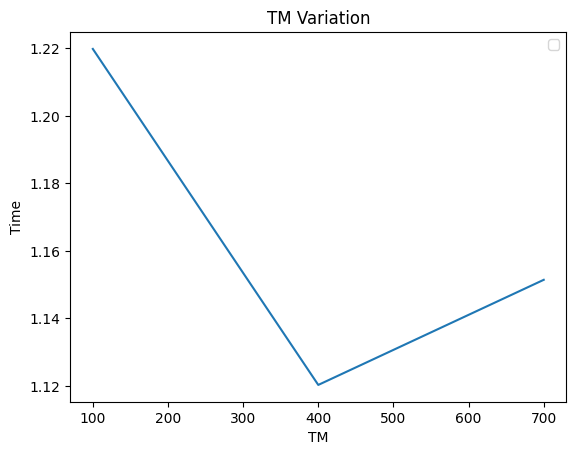

In [ ]:
import matplotlib.pyplot as plt
# Add more lines for other heuristics if needed
plt.xlabel('TM')
plt.ylabel('Time')
plt.title('TM Variation')
plt.legend()
plt.plot(Tms, tm_times, label='AG')

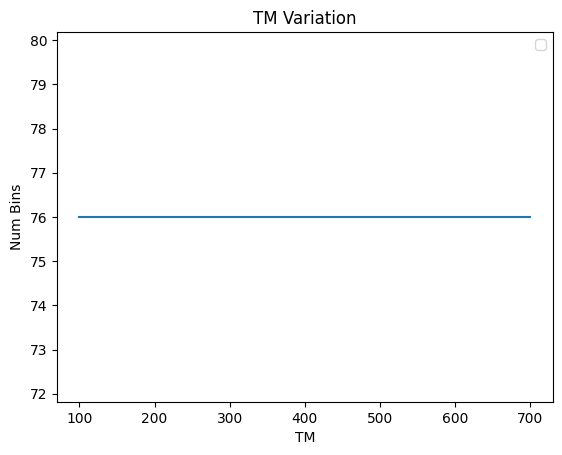

In [ ]:
plt.xlabel('TM')
plt.ylabel('Num Bins')
plt.title('TM Variation')
plt.legend()
plt.step(Tms, tm_performance, label='AG')

In [ ]:
#Pc
pc_config = generate_config
pc_times = []
pc_performance = []
for pc in Pcs :
  pc_config['crossover_probability'] = pc
  start = time()
  performance = population.generate_populations(pc_config, _print=False, _cpus=1)
  end = time()
  pc_performance.append(performance)
  pc_times.append(end-start)



ENDED after 11 generations, best solution is 76 bins


ENDED after 11 generations, best solution is 76 bins


ENDED after 11 generations, best solution is 76 bins


ENDED after 11 generations, best solution is 76 bins


In [ ]:
pc_times=[ t/10 for t in pc_times]

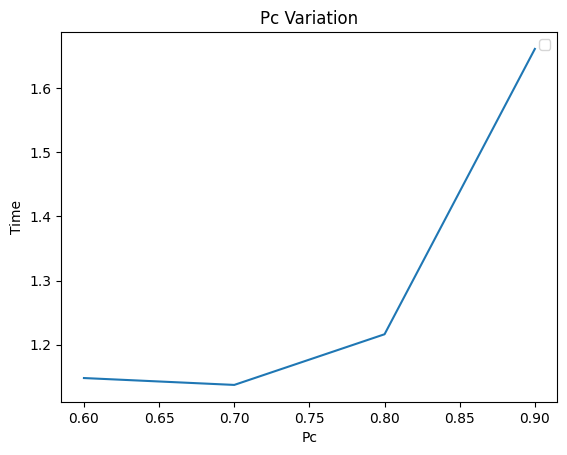

In [ ]:
import matplotlib.pyplot as plt
# Add more lines for other heuristics if needed
plt.xlabel('Pc')
plt.ylabel('Time')
plt.title('Pc Variation')
plt.legend()
plt.plot(Pcs, pc_times, label='AG')

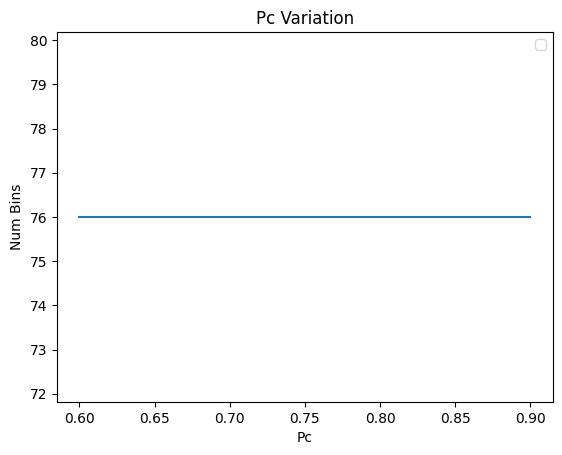

In [ ]:
import matplotlib.pyplot as plt
# Add more lines for other heuristics if needed
plt.xlabel('Pc')
plt.ylabel('Num Bins')
plt.title('Pc Variation')
plt.legend()
plt.plot(Pcs, pc_performance, label='AG')

In [ ]:
#pm
pm_config = generate_config
pm_times = []
pm_performance = []
for pm in Pms :
  pm_config['mutation_probability'] = pm
  start = time()
  performance = population.generate_populations(pm_config, _print=False, _cpus=1)
  end = time()
  pm_performance.append(performance)
  pm_times.append(end-start)



ENDED after 11 generations, best solution is 76 bins


ENDED after 11 generations, best solution is 76 bins


ENDED after 11 generations, best solution is 76 bins


ENDED after 11 generations, best solution is 76 bins


ENDED after 11 generations, best solution is 76 bins


In [ ]:
pm_times = [ t/10 for t in pm_times]

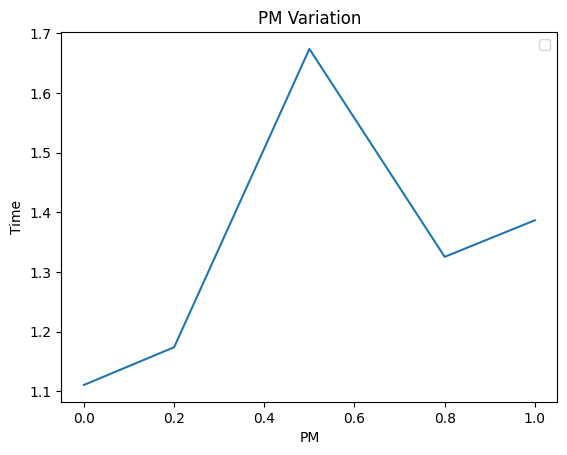

In [ ]:
import matplotlib.pyplot as plt
# Add more lines for other heuristics if needed
plt.xlabel('PM')
plt.ylabel('Time')
plt.title('PM Variation')
plt.legend()
plt.plot(Pms, pm_times, label='AG')

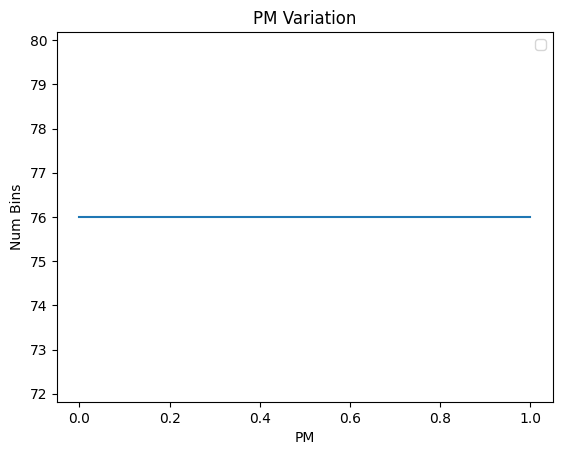

In [ ]:
# Add more lines for other heuristics if needed
plt.xlabel('PM')
plt.ylabel('Num Bins')
plt.title('PM Variation')
plt.legend()
plt.plot(Pms, pm_performance, label='AG')

In [ ]:
#pm1 = [0.01, 0.01, 0.05 , 0.1]
pm_config = generate_config
pm_times = []
pm_performance = []
for pm in Pms1 :
  pm_config['mutation_probability'] = pm
  start = time()
  performance = population.generate_populations(pm_config, _print=False, _cpus=1)
  end = time()
  pm_performance.append(performance)
  pm_times.append(end-start)



ENDED after 11 generations, best solution is 76 bins


ENDED after 11 generations, best solution is 76 bins


ENDED after 11 generations, best solution is 76 bins


ENDED after 11 generations, best solution is 76 bins


In [ ]:
pm_times = [t/10 for t in pm_times]

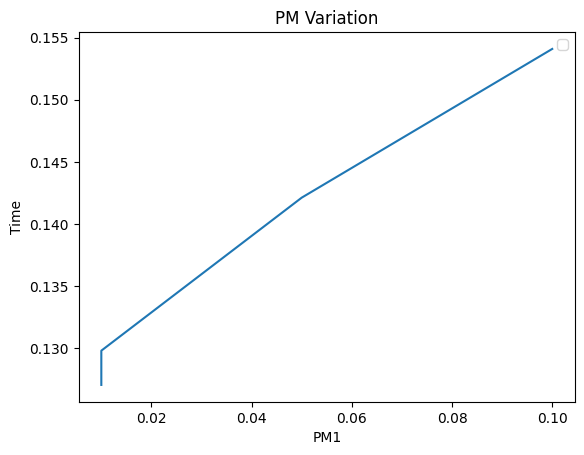

In [ ]:
import matplotlib.pyplot as plt
# Add more lines for other heuristics if needed
plt.xlabel('PM1')
plt.ylabel('Time')
plt.title('PM Variation')
plt.legend()
plt.plot(Pms1, pm_times, label='AG')

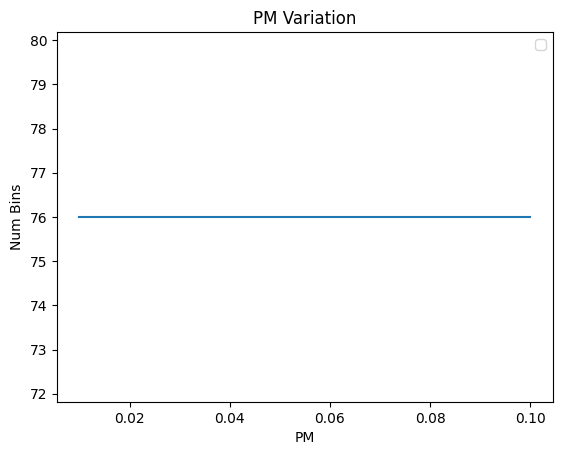

In [ ]:
plt.xlabel('PM')
plt.ylabel('Num Bins')
plt.title('PM Variation')
plt.legend()
plt.plot(Pms1, pm_performance, label='AG')

# Test RS

In [ ]:
#Tempeture
from time import time
cooling_rate = 0.9999
performance =[]
tempers = []
times_tempers = []
for i in range(1,6):
  start = time()
  best_state = simulated_annealing(items, bin_capacity, n ** i, cooling_rate, 5)
  end = time()
  times_tempers.append(end - start)
  tempers.append(n ** i)
  performance.append(len(best_state))

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
# Add more lines for other heuristics if needed
plt.xlabel('Temperture')
plt.ylabel('Num Bins')
plt.title('Tempture Variation')
plt.legend()
plt.step(tempers, performance, label='RS')
#plt.show()

In [ ]:
print(len(tempers))

In [ ]:
times_tempers  = [ t/10 for t in times_tempers ]

In [ ]:
import matplotlib.pyplot as plt
# Add more lines for other heuristics if needed
plt.xlabel('Temperture')
plt.ylabel('Time')
plt.title('Tempture Variation')
plt.legend()
plt.plot(tempers, times_tempers, label='RS')
#plt.show()

In [ ]:
#Cooling Rate
cooling_rates = [0.5, 0.6, 0.7, 0.8, 0.9, 0.9999]
performance =[]
tempers = []
times_cr = []
for cooling_rate in cooling_rates:
  start = time()
  best_state = simulated_annealing(items, bin_capacity, n ** 3, cooling_rate, 5)
  end = time()
  times_cr.append(end - start)
  performance.append(len(best_state))

In [ ]:
print(performance)

In [ ]:
times_cr = [ t/10 for t in times_cr]

In [ ]:
import matplotlib.pyplot as plt

plt.step(cooling_rates, performance, label='RS')
# Add more lines for other heuristics if needed

plt.xlabel('Cooling Rate')
plt.ylabel('Num Bins')
plt.title('Cooling Rates Variation')
plt.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cooling_rates,times_cr, label='RS')
# Add more lines for other heuristics if needed

plt.xlabel('Cooling Rate')
plt.ylabel('Time')
plt.title('Cooling Rates Variation')
plt.legend()

plt.show()

In [ ]:
import random
import math
import copy
import numpy as np
from time import time


def read_bpp_file(file_path):
    with open(file_path, 'r') as f:
        n = int(f.readline().strip())
        capacity = int(f.readline().strip())
        objects = [int(line.strip()) for line in f]
    return (n, capacity, objects)


(n , bin_capacity , items ) = read_bpp_file('Hard28_BPP900.txt')
items = {i:items[i] for i in range(n)}



class Item:
    def __init__(self, label: int = None, size: int = None):
        self._label = label  # index
        self._size = size  # weight


class Bin:
    def __init__(self, items: list = None, capacity: int = 0):
        if items is None:
            items = []
        self._items = items
        self._capacity = capacity

    def add_item(self, item: Item):
        self._items.append(item)
        self._capacity += item._size

    def get_labels(self) -> list[int]:  # get indexes
        return [item._label for item in self._items]


class Solution:
    def __init__(self, bins: list[Bin] = None, max_capacity: int = bin_capacity):
        if bins is None:
            bins = []
        self._bins = bins
        self._max_capacity = max_capacity
        self._fitness = self.calculate_fitness()

    def calculate_fitness(self):
        """somme(taille bin / max)² for each bin / nb bins"""
        '''if self._bins is []:
            return 1
        num_bins = len(self._bins)
        bins_capacity = np.asarray([_bin._capacity for _bin in self._bins], dtype=int)
        self._fitness = np.sum(np.power(bins_capacity / self._max_capacity, 2)) / num_bins
        return self._fitness'''
        self._fitness = len(self._bins) + sum((bin_capacity - bin._capacity / bin_capacity) for bin in self._bins) / (bin_capacity * len(self._bins))
        return self._fitness

    def count_items(self):
        return len([item for _bin in self._bins for item in _bin._items])

    def count_indexes(self):
        items = [item for _bin in self._bins for item in _bin._items]
        indexes = [item._label for item in items]
        return len(set(indexes))

    def affichage(self):
        return [bin.get_labels() for bin in self._bins]

    def __str__(self):
        return f"{self._fitness}: {affichage(self.affichage())}"



def next_fit(indexes: list[int]) -> Solution:
    random.shuffle(indexes)
    bins = []
    current_bin = Bin()
    for i in indexes:
        if current_bin._capacity + items[i] <= bin_capacity:
            current_bin.add_item(Item(label=i, size=items[i]))
        else:
            bins.append(current_bin)
            current_bin = Bin()
            current_bin.add_item(Item(label=i, size=items[i]))
    bins.append(current_bin)
    return Solution(bins)


def affichage(list_index: list[int]) -> list[int]:
    return [[items[i] for i in bin] for bin in list_index]


def generate_continent(n_teams: int) -> list[Solution]:
    indexes = list(items.keys())
    return np.array([next_fit(indexes) for _ in range(n_teams)], dtype=object)


def generate_preliminary(n_contients: int, n_teams: int) -> list[list[Solution]]:
    return np.array([generate_continent(n_teams) for _ in range(n_contients)], dtype=object)


"""def fitness(team: list[list[int]]):
    return len(team) + sum((bin_capacity - sum(bin) / bin_capacity) for bin in team) / (bin_capacity * len(team))"""




def crossover(father: Solution, mother: Solution):
    while True:
        two_points_father = np.random.randint(len(father._bins) + 1, size=2)
        two_points_mother = np.random.randint(len(mother._bins) + 1, size=2)
        if len(set(two_points_father)) == 2 and len(set(two_points_mother)) == 2:
            break
    two_points_father.sort()
    two_points_mother.sort()
    """choisir deux indexes for father and mother to do croisement a 2 points"""
    first_child = crossover_one_chromosome(chromosome=father, points_insert=two_points_father[1],
                                                genes=mother._bins[two_points_mother[0]:two_points_mother[1]])
    second_child = crossover_one_chromosome(chromosome=mother, points_insert=two_points_mother[0],
                                                genes=father._bins[two_points_father[0]:two_points_father[1]])
    return first_child, second_child


def crossover_one_chromosome(chromosome: Solution, points_insert: int, genes: list):
    """insert genes then completes with genes from chromosome"""
    child = Solution(genes, max_capacity=chromosome._max_capacity)
    take_labels = [_bin.get_labels() for _bin in genes]
    take_labels = [label for bin_labels in take_labels for label in bin_labels]
    left_bins = []
    right_bins = []
    free_items = []
    for i in range(len(chromosome._bins)):
        intersection = [label for label in chromosome._bins[i].get_labels() if label in take_labels]
        if len(intersection) == 0:
            if i < points_insert:
                left_bins.append(chromosome._bins[i])
            else:
                right_bins.append(chromosome._bins[i])
        else:
            for item in chromosome._bins[i]._items:
                if item._label not in intersection:
                    free_items.append(item)
    child._bins = left_bins + child._bins + right_bins
    return first_fit_descending(child, free_items)


def first_fit_descending(chromosome: Solution, items: list):
    """try to add leftover items in child's current bins else add new ones"""
    chromosome = copy.deepcopy(chromosome)
    objects = copy.deepcopy(items)
    objects = sorted(objects, key=lambda item: item._size, reverse=True)
    max_capacity = chromosome._max_capacity
    add_bins = []
    current_bin = Bin()
    _flag = False
    _count = 0
    for item in objects:
        _count += 1
        for _bin in chromosome._bins:
            if _bin._capacity + item._size <= max_capacity:
                _bin.add_item(item)
                _flag = True
                break
        if not _flag:
            if current_bin._capacity + item._size <= max_capacity:
                current_bin.add_item(item)
            else:
                add_bins.append(current_bin)
                current_bin = Bin()
                current_bin.add_item(item)
        _flag = False
    if current_bin._capacity > 0:
        add_bins.append(current_bin)
    chromosome._bins += add_bins
    return chromosome


def FIFA(n_iter: int, n_continents: int, n_teams: int):
    best_sol = None
    best_score = n
    preliminary = generate_preliminary(n_continents, n_teams)  # list of continents

    for _ in range(n_iter):
        finals = []
        for continent in preliminary:
            team1, team2 = sorted(continent, reverse=False, key=lambda team: team._fitness)[:2]
            finals.extend([team1, team2])

        champion = sorted(finals, reverse=False, key=lambda team: team._fitness)[0]
        if champion._fitness < best_score:
            print('found new best', champion._fitness, best_score, len(champion._bins))
            best_sol = champion
            best_score = champion._fitness

        next_preliminary = []
        for i in range(0, len(finals), 2):
            continent = finals[i: i + 2]
            for _ in range(0, n_teams - 2, 2):
                continent.extend(crossover(continent[0], continent[1]))
            next_preliminary.append(continent)
        preliminary = next_preliminary

    return best_sol


# Define the simulated annealing function
def simulated_annealing(items, bin_capacity, initial_temperature, cooling_rate, nb_iter, n_iter: int, n_continents: int, n_teams: int):
    # Define the initial states
    # current_state = initial_state(items, bin_capacity)
    current_state = affichage(FIFA(n_iter, n_continents, n_teams).affichage())
    current_energy = best_score = energy(current_state)
    best_state = current_state
    print("Start state", best_score)

    # Define the initial temperature
    current_temperature = initial_temperature
    start_time = time()

    # Loop until the temperature is too low
    while current_temperature > 1:
        # loop for nb_iter with same temperature
        for _ in range(nb_iter):
            # Pick a random neighbor state
            neighbor_state, diff = neighbor(current_state, bin_capacity)

            # Calculate the energy of the neighbor states
            neighbor_energy = energy(neighbor_state)

            # Calculate the energy difference
            energy_difference = (neighbor_energy - current_energy) * bin_capacity + diff

            # If the neighbor state has a lower energy, move to that state or with a certain probability
            if energy_difference < 0 or energy_difference > 0 and math.exp(-energy_difference / current_temperature) > random.random():
                current_state = neighbor_state
                current_energy = neighbor_energy

            # If current state better than the best one, update it
            if current_energy < best_score:
                best_state = current_state
                best_score = current_energy
        # Decrease the temperature
        current_temperature *= cooling_rate

    print('exe time', time() - start_time)
    # Return the best state found
    return best_state

# Define the initial state function
def initial_state(items, bin_capacity):
    # next fit wa9ila
    state = []
    bin = []
    for item in items:
        if sum(bin) + item <= bin_capacity:
            bin.append(item)
        else:
            state.append(bin)
            bin = [item]
    state.append(bin)
    return state

# Define the neighbor function
def neighbor(state, bin_capacity):
    i = random.randint(0, len(state)-1)  # random bin 1
    j = random.randint(0, len(state[i])-1)  # random object from bin 1
    k = random.randint(0, len(state)-1)  # random bin 2

    # if different bins and object from bin 1 can be added to bin 2, else do nothing
    if i != k and sum(state[k]) + state[i][j] <= bin_capacity:
        neighbor_state = copy.deepcopy(state)
        neighbor_state[k].append(neighbor_state[i].pop(j))
        if not neighbor_state[i]:  # remove bin 1 if it becomes empty
            neighbor_state.pop(i)
            return neighbor_state, 0
        return neighbor_state, sum(neighbor_state[i]) - sum(neighbor_state[k])
        # if nb of bins didn't change then we estimate the change by (i + object)² + k² - (i² + (k + object)²) = 2*object*(i - k) ~ i - k
        # the idea is to try to remplir un bin au maximum (min leftover space in a bin)
    return state, 0

# Define the energy function
def energy(state):
    return len(state)


"""sol = FIFA(50, 5, 5)
print(len(sol._bins), affichage(sol.affichage()), sol._fitness)"""
# Test the algorithm
initial_temperature = n ** 2
cooling_rate = 0.999

best_state = simulated_annealing(list(items.values()), bin_capacity, initial_temperature, cooling_rate, 5, 40, 6, 3)
print(best_state)
print(len(best_state))



found new best 98.99923493877552 200 98
found new best 5.9992516 98.99923493877552 94
found new best 3.9990486666666665 5.9992516 94
found new best 3.9990316666666668 3.9990486666666665 92
found new best 1.999435 3.9990316666666668 94
found new best 1.999215 1.999435 86
found new best 1.9990139999999998 1.999215 82
found new best 1.999 1.9990139999999998 86
Start state 86
exe time 0.9844985008239746
[[566, 423, 4], [592, 261, 143], [512, 388], [114, 153, 608], [482, 506], [535, 435], [587, 352, 45], [663, 99, 223], [531, 316, 144], [565, 285], [643, 233], [436, 458], [591, 283, 123], [644, 176, 166], [695, 263], [639, 203], [526, 208, 184, 30], [622, 237, 107], [597, 256, 120], [529, 392], [598, 356], [630, 345, 6], [597, 384], [564, 306, 123], [613, 158, 111, 115], [486, 472, 32], [580, 212], [533, 460, 7], [613, 84], [576, 395], [577, 131, 268], [698, 101], [525, 404, 67], [656, 250, 47], [654, 286], [570, 407], [409, 307, 283], [558, 95, 332, 11], [665, 250], [542, 402], [490, 433],